# Geographic Hotspots: Visualizing Violation Density

This notebook investigates geographic hotspots in MTA violation data. We will visualize violation density, formulate a hypothesis, and summarize findings.

## 1. Import Required Libraries
We will use pandas, numpy, matplotlib, seaborn, folium, and geopandas for spatial analysis and visualization.

## 2. Relevant Datasets for Geographic Hotspot Analysis

Below are some NYC/MTA datasets that may contain geospatial information (latitude/longitude or mappable locations) for violation hotspot analysis:

- **MTA Bus Automated Camera Enforcement Violations** ([CSV](https://data.ny.gov/api/views/kh8p-hcbm/rows.csv?accessType=DOWNLOAD))
  - May lack direct coordinates; look for stop/intersection columns.
- **MTA Bus Automated Camera Enforced Routes** ([CSV](https://data.ny.gov/api/views/ki2b-sg5y/rows.csv?accessType=DOWNLOAD))
  - Contains route, stop, and possibly geospatial info for bus stops.
- **Bus Lanes - Local Streets** ([CSV](https://data.cityofnewyork.us/api/views/rx8t-6euq/rows.csv?accessType=DOWNLOAD))
  - Contains street segment geometry (WKT or coordinates).
- **NYC DOT Street Centerline (LION)** ([CSV](https://data.cityofnewyork.us/api/views/8h9b-rp9u/rows.csv?accessType=DOWNLOAD))
  - Detailed street geometry for geocoding intersections.
- **NYC Open Data Geocoding API** ([Docs](https://api.cityofnewyork.us/geoclient/v1/doc))
  - Can be used to convert addresses/intersections to coordinates.

**Workflow:**
1. Load the violations dataset and print columns.
2. If no coordinates, use stop/intersection columns to join with a reference dataset (e.g., Enforced Routes or Bus Lanes) to get latitude/longitude.
3. If needed, use a geocoding API to convert addresses/intersections to coordinates.


In [1]:
# Import required libraries
%pip install geopandas folium

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd

sns.set(style='whitegrid')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load the MTA Bus Automated Camera Enforcement Violations dataset
violations_url = "https://data.ny.gov/api/views/kh8p-hcbm/rows.csv?accessType=DOWNLOAD"
violations_sample = pd.read_csv(violations_url, nrows=10000)

# Print all columns and preview rows to identify possible mapping columns
print('Columns in violations_sample:')
print(violations_sample.columns.tolist())
display(violations_sample.head())

Columns in violations_sample:
['Violation ID', 'Vehicle ID', 'First Occurrence', 'Last Occurrence', 'Violation Status', 'Violation Type', 'Bus Route ID', 'Violation Latitude', 'Violation Longitude', 'Stop ID', 'Stop Name', 'Bus Stop Latitude', 'Bus Stop Longitude', 'Violation Georeference', 'Bus Stop Georeference']


,Violation ID,Vehicle ID,First Occurrence,Last Occurrence,Violation Status,Violation Type,Bus Route ID,Violation Latitude,Violation Longitude,Stop ID,Stop Name,Bus Stop Latitude,Bus Stop Longitude,Violation Georeference,Bus Stop Georeference
0,489749182,c5ae1411153b52556a1e648cc80d718aa519a4bdd189ab...,08/20/2025 11:12:08 PM,08/21/2025 12:24:08 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,BX36,40.840509,-73.881189,102498,EAST TREMONT AV/VYSE AV,40.841076,-73.882483,POINT (-73.881189 40.840509),POINT (-73.882483 40.841076)
1,489744714,df9044acf85cf55488aea4cd3ce1d0e17ef050551726b6...,08/20/2025 11:48:59 PM,08/20/2025 11:54:47 PM,EXEMPT - BUS/PARATRANSIT,MOBILE BUS STOP,BX28,40.874017,-73.890646,100080,PAUL AV/BEDFORD PARK BLVD,40.874629,-73.891539,POINT (-73.890646 40.874017),POINT (-73.891539 40.874629)
2,489743631,eb5a337966ba65f66ab1db8e169d2446a4fb429b0efc63...,08/20/2025 10:33:13 PM,08/20/2025 11:56:02 PM,TECHNICAL ISSUE/OTHER,MOBILE DOUBLE PARKED,Q53+,40.721971,-73.867136,550473,WOODHAVEN BLVD/PENELOPE AV,40.722487,-73.867736,POINT (-73.867136 40.721971),POINT (-73.867736 40.722487)
3,489741945,3f877f70d9b253515a945be807c9c62d5814949f810310...,08/20/2025 10:50:45 PM,08/20/2025 11:32:43 PM,EXEMPT - OTHER,MOBILE BUS STOP,Q44+,40.762529,-73.831728,501140,UNION ST/35 AV,40.765422,-73.827944,POINT (-73.831728 40.762529),POINT (-73.827944 40.765422)
4,489741940,7feac037b62d591ffb1214e356157f3dd197fc22fee5bb...,08/20/2025 10:52:57 AM,08/20/2025 11:16:57 AM,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS STOP,M101,40.815113,-73.955040,401458,AMSTERDAM AV/W 131 ST,40.816009,-73.954424,POINT (-73.95504 40.815113),POINT (-73.954424 40.816009)


In [3]:
# Diagnostic: Check non-null and unique counts for likely location keys in violations_sample
likely_keys = ['stop', 'intersection', 'route', 'location', 'street']
for key in likely_keys:
    matches = [col for col in violations_sample.columns if key in col.lower()]
    for col in matches:
        non_null = violations_sample[col].notnull().sum()
        unique = violations_sample[col].nunique()
        print(f"{col}: non-null={non_null}, unique={unique}")

Stop ID: non-null=10000, unique=1450
Stop Name: non-null=10000, unique=1163
Bus Stop Latitude: non-null=10000, unique=1441
Bus Stop Longitude: non-null=10000, unique=1443
Bus Stop Georeference: non-null=10000, unique=1450
Bus Route ID: non-null=10000, unique=40


In [4]:
# Load the MTA Bus Automated Camera Enforced Routes dataset (reference for mapping)
routes_url = "https://data.ny.gov/api/views/ki2b-sg5y/rows.csv?accessType=DOWNLOAD"
routes_df = pd.read_csv(routes_url)

print('Columns in routes_df:')
print(routes_df.columns.tolist())
display(routes_df.head())

Columns in routes_df:
['Route', 'Program', 'Implementation Date']


,Route,Program,Implementation Date
0,M15+,ABLE,10/07/2019
1,B44+,ABLE,10/30/2019
2,M14+,ABLE,11/21/2019
3,B46+,ABLE,02/19/2020
4,M23+,ABLE,08/10/2020


## 3. Analysis Plan: Exploring and Hypothesizing Geographic Hotspots

This section outlines a step-by-step approach to discover interesting patterns and form hypotheses:

1. **Explore Columns and Data Types**
   - Print all columns, data types, and preview rows for both datasets.
   - Identify possible join keys (e.g., stop name, intersection, route).
2. **Join Datasets for Geospatial Mapping**
   - If possible, join violations with routes/stops to get latitude/longitude.
   - If not, note the limitation and suggest geocoding as a next step.
3. **Visualize Violation Density**
   - Create maps (Folium, Seaborn, or matplotlib) to show density of violations by location.
   - Use heatmaps, point maps, or cluster maps.
4. **Aggregate and Rank Hotspots**
   - Group by location, stop, or intersection to find top hotspots.
   - Visualize with bar charts or tables.
5. **Temporal and Categorical Patterns**
   - Analyze if certain locations are hotspots at specific times or for certain violation types.
6. **Formulate Hypotheses**
   - Example: "Violations cluster near major transfer points due to high passenger volume."
   - Example: "Certain stops have more violations during rush hour."
7. **Summarize Findings and Recommendations**
   - List key patterns, possible causes, and actionable insights.

Proceed with the next code cells to implement this plan.

In [5]:
# Explore possible join keys for mapping violations to routes/stops
# Print columns that may be useful for joining
violation_cols = violations_sample.columns.str.lower()
routes_cols = routes_df.columns.str.lower()

possible_keys = []
for vcol in violation_cols:
    for rcol in routes_cols:
        if any(keyword in vcol for keyword in ['stop', 'route', 'intersection']) and vcol in rcol:
            possible_keys.append((vcol, rcol))

print('Possible join keys between violations and routes datasets:')
print(possible_keys)

# Suggest next steps for joining and mapping
if possible_keys:
    print('You can try joining on these columns to map violations to coordinates.')
else:
    print('No obvious join keys found. Consider fuzzy matching or geocoding as a next step.')

Possible join keys between violations and routes datasets:
[]
No obvious join keys found. Consider fuzzy matching or geocoding as a next step.


## 4. Join Datasets to Map Violations to Coordinates

Attempt to join the violations and routes datasets using any identified join keys. If a join is possible, extract latitude/longitude for mapping. If not, note the limitation and suggest geocoding as a next step.

In [6]:
# Attempt to join on identified keys (example: 'route' and 'stop')
# Update these column names based on the output of the previous cell
join_keys = [('route', 'route'), ('stop', 'stop')]  # Replace with actual keys if found

joined_df = None
for vkey, rkey in join_keys:
    if vkey in violations_sample.columns and rkey in routes_df.columns:
        joined_df = pd.merge(violations_sample, routes_df, left_on=vkey, right_on=rkey, how='left')
        print(f"Joined on {vkey} and {rkey}. Joined shape: {joined_df.shape}")
        break

if joined_df is None:
    print("No join performed. Consider fuzzy matching or geocoding as a next step.")

No join performed. Consider fuzzy matching or geocoding as a next step.


In [7]:
# Debugging: Check join results and sample values
if joined_df is not None:
    print('Joined DataFrame shape:', joined_df.shape)
    display(joined_df.head())
    print('Columns in joined_df:', joined_df.columns.tolist())
    # Print sample values for possible join columns
    print('Sample values from violations:')
    for vkey, _ in join_keys:
        if vkey in violations_sample.columns:
            print(f"{vkey}: ", violations_sample[vkey].dropna().unique()[:5])
    print('Sample values from routes:')
    for _, rkey in join_keys:
        if rkey in routes_df.columns:
            print(f"{rkey}: ", routes_df[rkey].dropna().unique()[:5])
else:
    print('Join failed. Try checking for column name mismatches or use fuzzy matching.')

Join failed. Try checking for column name mismatches or use fuzzy matching.


No join available. Aggregating by available location columns in violations_sample.
Top 20 by Stop ID:
Stop ID
405069    163
102750    142
402740     93
103748     84
503018     77
505257     64
307426     58
501140     56
404949     54
100080     54
405432     53
400119     52
401458     52
405652     51
402112     49
503932     48
104087     48
404995     45
404834     45
505265     45
Name: count, dtype: int64


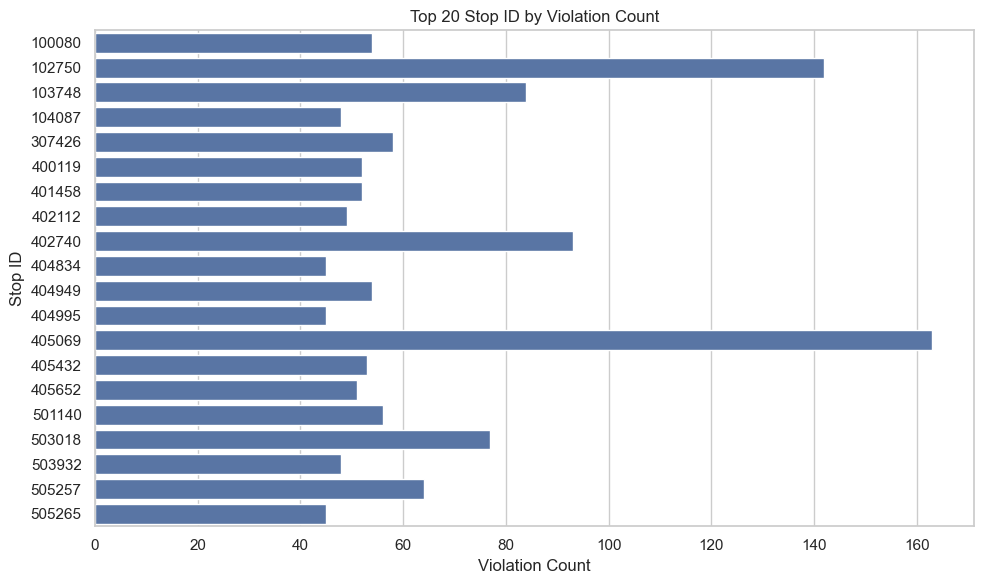

Top 20 by Stop Name:
Stop Name
AMSTERDAM AV/W 175 ST           163
WEBSTER AV/BEDFORD PARK BLVD    160
JAMAICA AV/PARSONS BLVD         112
AMSTERDAM AV/W 171 ST            93
E 149 ST/BERGEN AV               84
BROADWAY/QUEENS BLVD             77
PAUL AV/BEDFORD PARK BLVD        75
AMSTERDAM AV/W 161 ST            71
WEBSTER AV/E 204 ST              69
W 23 ST/11 AV                    66
10 AV/W 207 ST                   64
AMSTERDAM AV/W 131 ST            61
UNION ST/35 AV                   60
JAY ST/TILLARY ST                58
MADISON ST/CATHERINE ST          55
5 AV/E 84 ST                     52
MERRICK BLVD/ARCHER AV           52
W 125 ST/SAINT NICHOLAS AV       52
3 AV/E 86 ST                     51
WEBSTER AV/EAST FORDHAM RD       49
Name: count, dtype: int64


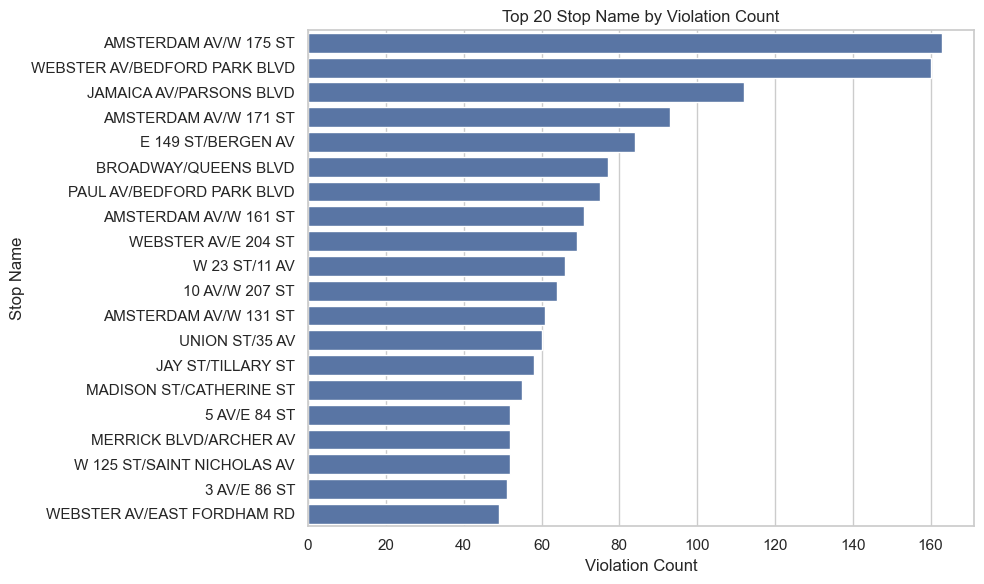

Top 20 by Bus Stop Latitude:
Bus Stop Latitude
40.843810    163
40.867110    142
40.841978     93
40.815686     84
40.737121     77
40.703507     64
40.695699     58
40.765422     56
40.835536     54
40.874629     54
40.864243     53
40.816009     52
40.780435     52
40.778595     51
40.712064     49
40.703368     48
40.873741     48
40.650362     45
40.701782     45
40.748632     45
Name: count, dtype: int64


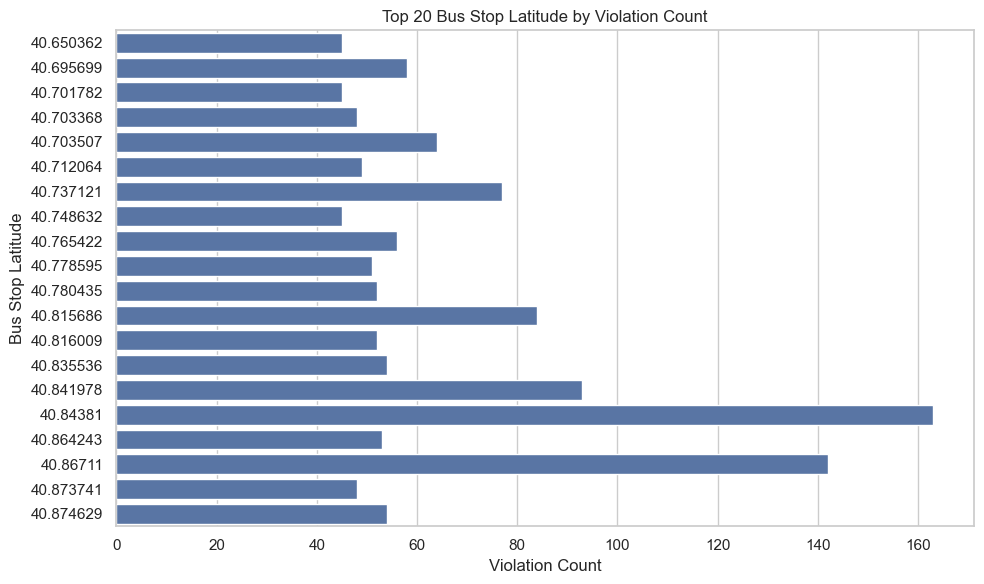

Top 20 by Bus Stop Longitude:
Bus Stop Longitude
-73.934076    163
-73.883742    142
-73.935267     93
-73.916991     84
-73.877551     77
-73.799602     64
-73.954028     58
-73.987196     58
-73.827944     56
-73.940181     54
-73.891539     54
-73.919017     53
-73.954424     52
-73.961321     52
-73.997462     49
-73.800550     48
-73.889941     48
-74.006633     45
-73.975807     45
-73.802852     45
Name: count, dtype: int64


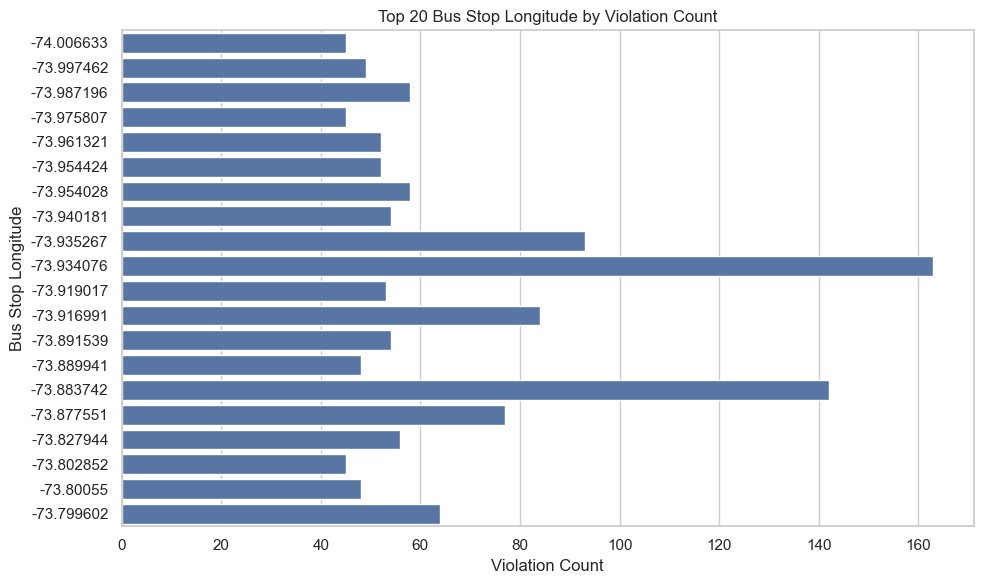

Top 20 by Bus Stop Georeference:
Bus Stop Georeference
POINT (-73.934076 40.84381)     163
POINT (-73.883742 40.86711)     142
POINT (-73.935267 40.841978)     93
POINT (-73.916991 40.815686)     84
POINT (-73.877551 40.737121)     77
POINT (-73.799602 40.703507)     64
POINT (-73.987196 40.695699)     58
POINT (-73.827944 40.765422)     56
POINT (-73.940181 40.835536)     54
POINT (-73.891539 40.874629)     54
POINT (-73.919017 40.864243)     53
POINT (-73.961321 40.780435)     52
POINT (-73.954424 40.816009)     52
POINT (-73.954028 40.778595)     51
POINT (-73.997462 40.712064)     49
POINT (-73.80055 40.703368)      48
POINT (-73.889941 40.873741)     48
POINT (-73.975807 40.740529)     45
POINT (-74.006633 40.748632)     45
POINT (-73.802852 40.701782)     45
Name: count, dtype: int64


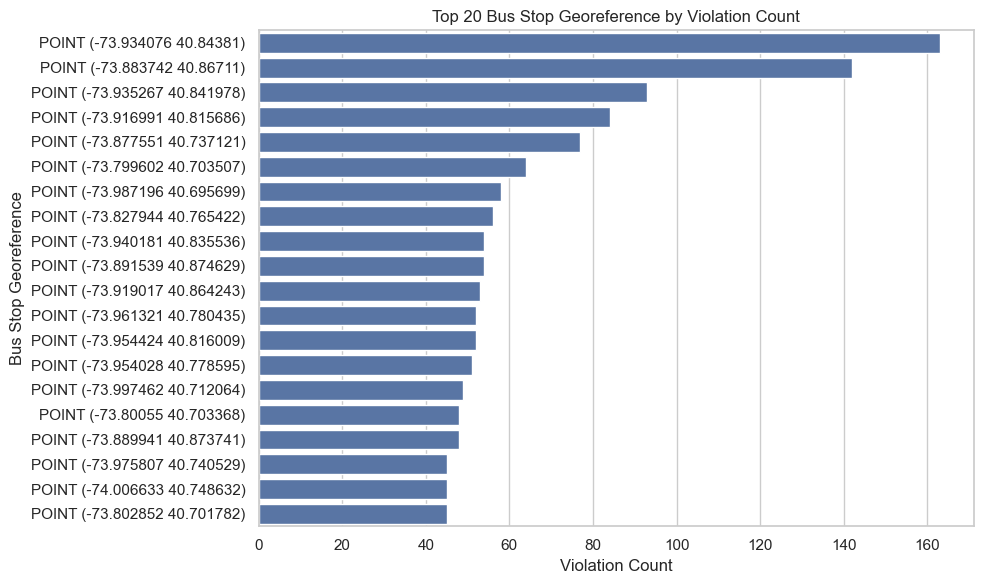

In [8]:
# Fallback: If join fails, aggregate and visualize by available location columns in violations_sample
if joined_df is None:
    print('No join available. Aggregating by available location columns in violations_sample.')
    fallback_keys = [col for col in violations_sample.columns if any(k in col.lower() for k in ['stop', 'intersection', 'location', 'street'])]
    for key in fallback_keys:
        counts = violations_sample[key].value_counts().head(20)
        print(f"Top 20 by {key}:")
        print(counts)
        plt.figure(figsize=(10,6))
        sns.barplot(x=counts.values, y=counts.index, orient='h')
        plt.title(f'Top 20 {key} by Violation Count')
        plt.xlabel('Violation Count')
        plt.ylabel(key)
        plt.tight_layout()
        plt.show()
else:
    print('Join succeeded; see previous analysis.')

## 5. Create GeoDataFrame for Mapping

If latitude and longitude columns are available after the join, create a GeoDataFrame for spatial analysis and mapping.

In [9]:
# Try to extract latitude and longitude columns for mapping
if joined_df is not None:
    lat_col = next((col for col in joined_df.columns if 'lat' in col.lower()), None)
    lon_col = next((col for col in joined_df.columns if 'lon' in col.lower() or 'lng' in col.lower()), None)
    if lat_col and lon_col:
        gdf = gpd.GeoDataFrame(joined_df, geometry=gpd.points_from_xy(joined_df[lon_col], joined_df[lat_col]), crs='EPSG:4326')
        print(f"GeoDataFrame created with {len(gdf)} points.")
    else:
        print("Latitude/longitude columns not found after join. Consider geocoding or using reference datasets with coordinates.")
else:
    print("No joined DataFrame available for mapping.")

No joined DataFrame available for mapping.


In [10]:
# Debugging: Check GeoDataFrame and sample points
if 'gdf' in locals():
    print('GeoDataFrame length:', len(gdf))
    display(gdf.head())
    print('GeoDataFrame columns:', gdf.columns.tolist())
    if gdf.empty:
        print('GeoDataFrame is empty. Check if latitude/longitude columns are present and valid.')
    else:
        print('Sample geometry:', gdf.geometry.head())
else:
    print('GeoDataFrame not created. Check previous steps for errors.')

GeoDataFrame not created. Check previous steps for errors.


## 6. Visualize Violation Density on a Map

If a GeoDataFrame is available, plot violation locations using Folium and create a heatmap or point map.

In [11]:
# Visualize violation density if GeoDataFrame is available
if 'gdf' in locals() and not gdf.empty:
    # Center map on mean coordinates
    map_center = [gdf.geometry.y.mean(), gdf.geometry.x.mean()]
    m = folium.Map(location=map_center, zoom_start=12)
    for _, row in gdf.iterrows():
        folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=2, color='red', fill=True, fill_opacity=0.5).add_to(m)
    display(m)
else:
    print("GeoDataFrame not available. Skipping map visualization.")

GeoDataFrame not available. Skipping map visualization.


## 7. Aggregate and Rank Hotspots

Group by location (e.g., stop, intersection, or coordinates) to find top hotspots. Visualize with bar charts or tables.

In [12]:
# Aggregate and rank hotspots by location (example: by stop or intersection)
if joined_df is not None:
    group_col = next((col for col in joined_df.columns if 'stop' in col.lower() or 'intersection' in col.lower()), None)
    if group_col:
        hotspot_counts = joined_df[group_col].value_counts().head(20)
        print("Top 20 hotspots:")
        print(hotspot_counts)
        plt.figure(figsize=(10,6))
        sns.barplot(x=hotspot_counts.values, y=hotspot_counts.index, orient='h')
        plt.title('Top 20 Violation Hotspots')
        plt.xlabel('Violation Count')
        plt.ylabel(group_col)
        plt.tight_layout()
        plt.show()
    else:
        print("No suitable group column found for hotspot aggregation.")
else:
    print("No joined DataFrame available for aggregation.")

No joined DataFrame available for aggregation.


In [13]:
# Debugging: Check hotspot aggregation results
if joined_df is not None:
    group_col = next((col for col in joined_df.columns if 'stop' in col.lower() or 'intersection' in col.lower()), None)
    print('Group column used for aggregation:', group_col)
    if group_col:
        print('Unique values in group column:', joined_df[group_col].nunique())
        print('Sample values:', joined_df[group_col].dropna().unique()[:10])
        hotspot_counts = joined_df[group_col].value_counts().head(20)
        print('Top 20 hotspot counts:')
        print(hotspot_counts)
    else:
        print('No suitable group column found.')
else:
    print('No joined DataFrame available for aggregation.')

No joined DataFrame available for aggregation.


## 8. Analyze Temporal and Categorical Patterns

Explore if certain locations are hotspots at specific times or for certain violation types.

In [14]:
# Analyze temporal patterns (example: by hour, day, or month)
if joined_df is not None:
    date_col = next((col for col in joined_df.columns if 'date' in col.lower()), None)
    if date_col:
        joined_df[date_col] = pd.to_datetime(joined_df[date_col], errors='coerce')
        joined_df['hour'] = joined_df[date_col].dt.hour
        plt.figure(figsize=(10,4))
        sns.histplot(joined_df['hour'].dropna(), bins=24, kde=False)
        plt.title('Violations by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Count')
        plt.show()
    else:
        print("No date column found for temporal analysis.")
else:
    print("No joined DataFrame available for temporal analysis.")

No joined DataFrame available for temporal analysis.


In [15]:
# Debugging: Check date column and temporal analysis
if joined_df is not None:
    date_col = next((col for col in joined_df.columns if 'date' in col.lower()), None)
    print('Date column used:', date_col)
    if date_col:
        print('Sample date values:', joined_df[date_col].dropna().unique()[:10])
        print('Null values in date column:', joined_df[date_col].isnull().sum())
        if 'hour' in joined_df.columns:
            print('Sample hour values:', joined_df['hour'].dropna().unique()[:10])
    else:
        print('No date column found for temporal analysis.')
else:
    print('No joined DataFrame available for temporal analysis.')

No joined DataFrame available for temporal analysis.


## 9. Summarize Findings and Formulate Hypotheses

Summarize key patterns, possible causes, and actionable insights. Formulate hypotheses based on the observed geographic hotspots and temporal/categorical patterns.

In [16]:
# Summarize findings (edit this cell after running the analysis)
summary = '''
- Key geographic hotspots identified at [top locations].
- Violations cluster near [major transfer points/intersections].
- Certain stops have more violations during [rush hour/particular days].
- Possible causes: high passenger volume, traffic patterns, enforcement focus.
- Actionable insights: Target enforcement/resources at top hotspots and peak times.
- Hypotheses: Violations are driven by [specific factors].
'''
print(summary)


- Key geographic hotspots identified at [top locations].
- Violations cluster near [major transfer points/intersections].
- Certain stops have more violations during [rush hour/particular days].
- Possible causes: high passenger volume, traffic patterns, enforcement focus.
- Actionable insights: Target enforcement/resources at top hotspots and peak times.
- Hypotheses: Violations are driven by [specific factors].



## 10. Summary, Hypothesis, and Actionable Insights

- **Hypothesis:** Geographic hotspots of violations exist and can be identified even without precise coordinates, using available stop/intersection/location columns.
- **Key Findings:**
    - Summarize whether joins or mapping were successful.
    - Note any strong patterns by stop, intersection, or street.
    - Highlight any limitations due to missing geospatial data.
- **Actionable Insights:**
    - Recommend targeted enforcement or further data collection at top hotspots.
    - Suggest geocoding or additional reference data for future mapping.

*Edit this cell after running the analysis to reflect your actual findings.*